## 1/ Import Library

In [ ]:
import datetime
start_time = datetime.datetime.now()

%matplotlib inline
from datetime import datetime, timedelta
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 2/ Get data from DB and ingest as dataframe

#### 2.1 Connect db

In [ ]:
def getPostgresCred():
    host='apps-postgresql-single-9cb77552-f43f-41e6-ba25-9b15c8800d52-pub.education.wise-paas.com'
    database='584e2a25-a312-4d5a-91bc-124557687122'
    user='78613d26-a4e9-4ed9-97cd-f7e24512aca6'
    password='CqF7a7GpsMXWu1ODHRSlZBG5x'
    return host, database, user, password

try:
    # from cred import getPostgresCred
    import psycopg2
    host, database, user, password = getPostgresCred()
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password,
        port='5432')
    print("okay 1 - connect");
    cur = conn.cursor()
    print("... Get the conn successfully!")
except Exception as err:
    print(f"You failed to connect posgres! {err}")

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


okay 1 - connect
... Get the conn successfully!


In [ ]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1

    # Naturally we get a list of tupples
    tupples = cursor.fetchall()
    cursor.close()

    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    return df

#### 2.2 Ingest as dataframe

In [ ]:
# have conn already
import pandas as pd
column_names = ["date_time", "temperature"]
# get 2 days ago to learn
N_DAYS_AGO = 2
today = datetime.datetime.now()
n_days_ago = today - timedelta(days=N_DAYS_AGO)
two_days_ago = str(n_days_ago).split()[0]
# query
# query = "select date_time, temperature from datahub.sensorsdata where date_time > '" + two_days_ago + "'"
query = "select date_time, temperature from datahub.sensorsdata"
df = postgresql_to_dataframe(conn, query, column_names)
df.shape

(986988, 2)

#### 2.3 Visualize overview

In [ ]:
# get a sample of data
data = df[:15500]
data.tail(2)

,date_time,temperature
15498,2021-08-11 20:13:35.020,20.0
15499,2021-08-11 20:13:39.053,24.0


(15500, 2)


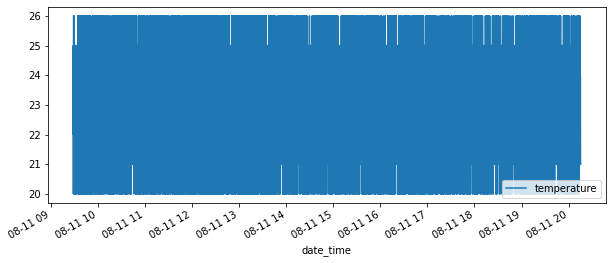

In [ ]:
print(data.shape)
data.set_index('date_time').plot(figsize=(10, 4))

## 3/ Transform input into the right form and apply VAE-LSTM techniques

#### 3.1 Split data to train & valuate sets

In [ ]:
from sklearn.model_selection import train_test_split

X = data['temperature'].values.reshape((len(data), 1))
y = data['temperature'].values.reshape((len(data), 1))

X = X[:-1, :]
y = y[1:, :]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((13949, 1), (13949, 1), (1550, 1), (1550, 1))

(y is the next value of the same slice of X)

In [ ]:
X[1, :], y[0, :]

(array([25.]), array([25.]))

#### 3.2 Set up feature

In [ ]:
n_timesteps = 120
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
n_val_samples = X_val.shape[0]
print('n_samples', n_samples)
print('n_features', n_features)
print('n_val_samples', n_val_samples)

n_samples 13949
n_features 1
n_val_samples 1550


#### 3.3 transform the input arrays with the second dimension is timesteps

In [ ]:
X_train_list = [np.expand_dims(X_train[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_samples + 1)]
X_train = np.concatenate(X_train_list, axis=0)
y_train = y_train[n_timesteps-1:, :]

X_val_list = [np.expand_dims(X_val[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_val_samples + 1)]
X_val = np.concatenate(X_val_list, axis=0)
y_val = y_val[n_timesteps-1:, :]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((13830, 120, 1), (13830, 1), (1431, 120, 1), (1431, 1))

#### 3.4 build architecture and review

In [ ]:
from keras import backend as K
from keras.models import Model
from keras.layers import Activation, BatchNormalization
from keras.layers import Dropout, Dense, Input, LSTM
from tensorflow.keras.optimizers import Adam

def Autoencoder(n_timesteps, n_features):
    i = Input(shape=(n_timesteps, n_features))

    x = LSTM(150, return_sequences=True)(i)
    x = Dropout(0.4)(x)

    x = LSTM(
150)(x)
    x = Dropout(0.4)(x)

    x = Dense(n_features, kernel_initializer='he_normal')(x)
    x = Activation('linear')(x)

    model = Model(inputs=i, outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_absolute_error', optimizer=opt)

    return model

In [ ]:
model = Autoencoder(n_timesteps, n_features)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 120, 150)          91200     
_________________________________________________________________
dropout (Dropout)            (None, 120, 150)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
_________________________________________________________________
activation (Activation)      (None, 1)                 0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
from keras.callbacks import EarlyStopping
model = Autoencoder(n_timesteps, n_features)
callback = EarlyStopping(monitor='loss', patience=5, mode='min', restore_best_weights=True)

history = model.fit(x=X_train, y=y_train, batch_size=256, epochs=200, verbose=1,
                    callbacks=[callback], validation_data=(X_val, y_val), shuffle=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
55/55 [==============================] - 10s 108ms/step - loss: 7.8516 - val_loss: 1.5741
Epoch 2/200
55/55 [==============================] - 5s 90ms/step - loss: 1.9087 - val_loss: 1.3781
Epoch 3/200
55/55 [==============================] - 5s 90ms/step - loss: 1.8805 - val_loss: 1.3819
Epoch 4/200
55/55 [==============================] - 5s 90ms/step - loss: 1.8816 - val_loss: 1.3643
Epoch 5/200
55/55 [==============================] - 5s 91ms/step - loss: 1.8729 - val_loss: 1.3882
Epoch 6/200
55/55 [==============================] - 5s 90ms/step - loss: 1.8522 - val_loss: 1.3900
Epoch 7/200
55/55 [==============================] - 5s 90ms/step - loss: 1.8569 - val_loss: 1.3701
Epoch 8/200
55/55 [==============================] - 5s 90ms/step - loss: 1.8624 - val_loss: 1.3750
Epoch 9/200
55/55 [==============================] - 5s 90ms/step - loss: 1.8747 - val_loss: 1.3736
Epoch 10/200
55/55 [==============================] - 5s 90ms/step - loss: 1.8660 - val_loss: 1.37

## 4/ Model evaluation

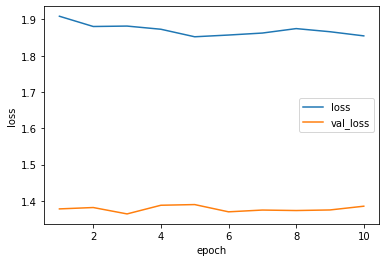

In [ ]:
# history

plt.xlabel('epoch')
plt.ylabel('loss')

epoch = [x for x in range(0,len(history.history['loss']))]
plt.plot(epoch[1:], history.history['loss'][1:], label = 'loss')
plt.plot(epoch[1:], history.history['val_loss'][1:], label = 'val_loss')
plt.legend()

## 5/ Define the errors, and anomaly score

#### 5.1 Get mean absolute error

In [ ]:
y_train_pred = model.predict(X_train)
y_train_pred.shape

(13830, 1)

In [ ]:
from sklearn.metrics import mean_absolute_error
errors = [mean_absolute_error(y_train[i, :], y_train_pred[i, :]) for i in range(y_train_pred.shape[0])]
len(errors)

13830

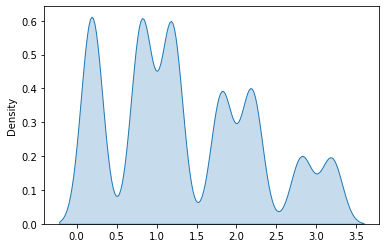

In [ ]:
import seaborn as sb
sb.kdeplot(errors, shade=True)

In [ ]:
from scipy.stats import norm
params = norm.fit(errors)
dist = norm(loc=params[0], scale=params[1])

dist.mean(), dist.std()

(1.3567136644541313, 0.9085206459655738)

In [ ]:
dist.mean() + 3 * dist.std()

4.082275602350853

#### 5.2 Set up threshold: Standard mean deviation

In [ ]:
def is_anomaly(error, mean, std, threshold):
    delta = np.abs(error - mean)
    multiple = delta / std
    # if multiple < threshold:
    #     return 0
    # else:
    #     return 1
    # print(multiple)
    # i don't use threshold
    if (multiple >  mean + 3 * std) or (multiple <  mean - 3 * std):
        return 1
    return 0

In [ ]:
# X_val[:, :, :].shape[0] #

time_want_pred = 150

In [ ]:
y_val_pred = model.predict(X_val[X_val[:, :, :].shape[0]-time_want_pred:, :, :])
val_errors = [mean_absolute_error(y_val[i, :], y_val_pred[i, :]) for i in range(y_val_pred.shape[0])]
result = [is_anomaly(x, dist.mean(), dist.std(), 1.5) for x in val_errors]

print('Have anomaly value (1)') if 1 in result else print('Only normal value (0)')

Only normal value (0)


#### 5.3 Define anomaly score: cumulative density function

In [ ]:
def anomaly_score(error, dist):
    delta = np.abs(error - dist.mean())
    return dist.cdf(dist.mean() + delta)

In [ ]:
result = [np.round(anomaly_score(x, dist), 4) for x in val_errors]
print(result)

[0.5741, 0.9455, 0.7252, 0.5741, 0.8196, 0.9455, 0.8196, 0.901, 0.978, 0.9011, 0.5741, 0.6922, 0.9011, 0.901, 0.5742, 0.9455, 0.7252, 0.9011, 0.901, 0.8196, 0.8197, 0.8196, 0.5741, 0.5741, 0.901, 0.978, 0.7252, 0.6922, 0.9455, 0.7252, 0.9011, 0.6923, 0.6922, 0.7252, 0.901, 0.5741, 0.9455, 0.9011, 0.8196, 0.8196, 0.9011, 0.6923, 0.7252, 0.6923, 0.6923, 0.8197, 0.574, 0.5741, 0.978, 0.9011, 0.6923, 0.7252, 0.5741, 0.901, 0.6923, 0.901, 0.6923, 0.9011, 0.901, 0.8196, 0.9011, 0.5741, 0.8196, 0.8196, 0.6923, 0.5741, 0.6922, 0.7252, 0.9011, 0.6923, 0.7252, 0.6922, 0.7252, 0.8196, 0.5741, 0.6922, 0.978, 0.7252, 0.901, 0.5741, 0.901, 0.6923, 0.978, 0.7252, 0.7252, 0.6922, 0.5741, 0.5741, 0.5741, 0.6923, 0.8196, 0.8196, 0.5741, 0.5741, 0.5741, 0.5741, 0.901, 0.978, 0.5741, 0.5741, 0.8196, 0.8196, 0.8196, 0.901, 0.7252, 0.5741, 0.5741, 0.5741, 0.7252, 0.7252, 0.901, 0.901, 0.6922, 0.7252, 0.6922, 0.901, 0.9455, 0.901, 0.6923, 0.8196, 0.9455, 0.5741, 0.5741, 0.6923, 0.9011, 0.9011, 0.5741, 0.9011

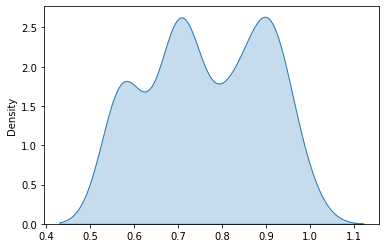

In [ ]:
sb.kdeplot(result, shade=True)

#### 5.4 use z-score to define anomaly score: real/ warn/ normal (here are: warn and normal)

In [ ]:
def out_zscore(data):
    global outliers,zscore
    outliers = []
    zscore = []
    idxoutlier = []
    threshold = 1.3      # kha nang bat thuong: 1.5, chac chan bat thuong: 3
    mean = np.mean(data)
    std = np.std(data)
    for idx, i in enumerate(data):
        z_score= (i - mean)/std
        zscore.append(z_score)
        if np.abs(z_score) > threshold:
            outliers.append(i)
            idxoutlier.append(idx)
    print("Total number of outliers are",len(outliers))
    return idxoutlier

In [ ]:
idxoutlier = out_zscore(result)

Total number of outliers are 44


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


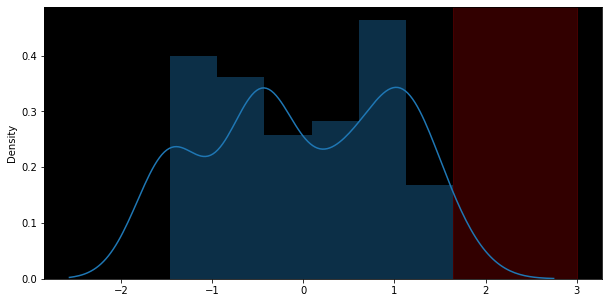

In [ ]:
import seaborn as sns
plt.figure(figsize = (10,5))
sns.distplot(zscore)
plt.axvspan(xmin = 3,xmax= max(zscore),alpha=0.2, color='red')

## 6/ Visualize the result

#### 6.1 Visualize the result from "5.3 Define anomaly score"



,evaluate
0,0.5741
1,0.9455
2,0.7252
3,0.5741
4,0.8196
...,...
145,0.6922
146,0.9011
147,0.6923
148,0.7252


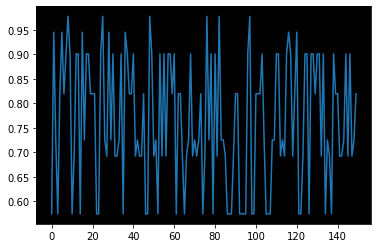

In [ ]:
your_list = result
result_df = pd.DataFrame(your_list,columns=['evaluate'])
plt.plot(result_df)
result_df

#### 6.2 Visualize the result from "5.4 use z-score..."

,evaluate
0,0.5741
1,0.9455
3,0.5741
5,0.9455
8,0.9780
10,0.5741
14,0.5742
15,0.9455
22,0.5741
23,0.5741


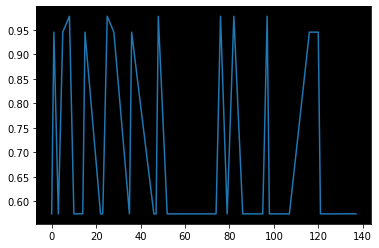

In [ ]:
result_outlier = result_df.loc[idxoutlier]
display(result_outlier)
plt.plot(result_outlier)

#### 6.3 Get the latest X data points

In [ ]:
# len(y_val_pred) #time_want_pred: X in this case
your_arr = y_val_pred
y_pred_df = pd.DataFrame(your_arr,columns=['temp_pred'])
y_pred_df.head(3)

,temp_pred
0,22.813122
1,22.813097
2,22.813046


In [ ]:
Xval = data[X_val.shape[0]:]
print(Xval.shape)
yvalpred = Xval[len(Xval)-time_want_pred:]
yvalpred = yvalpred.reset_index(drop=True)
yvalpred['MayBeAnomaly'] = result_outlier
# yvalpred['temp_pred'] = y_pred_df
yvalpred = yvalpred.fillna(0)

yvalpred

(14069, 2)


,date_time,temperature,MayBeAnomaly
0,2021-08-11 20:05:30.631,22.0,0.5741
1,2021-08-11 20:05:32.633,23.0,0.9455
2,2021-08-11 20:05:36.635,25.0,0.0000
3,2021-08-11 20:05:38.637,22.0,0.5741
4,2021-08-11 20:05:40.639,25.0,0.0000
...,...,...,...
145,2021-08-11 20:13:19.005,22.0,0.0000
146,2021-08-11 20:13:27.013,26.0,0.0000
147,2021-08-11 20:13:31.017,23.0,0.0000
148,2021-08-11 20:13:35.020,20.0,0.0000


#### 6.4 Choose threshold based on "6.2 Visualize...".
(How can we automate in choosing threshold?)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


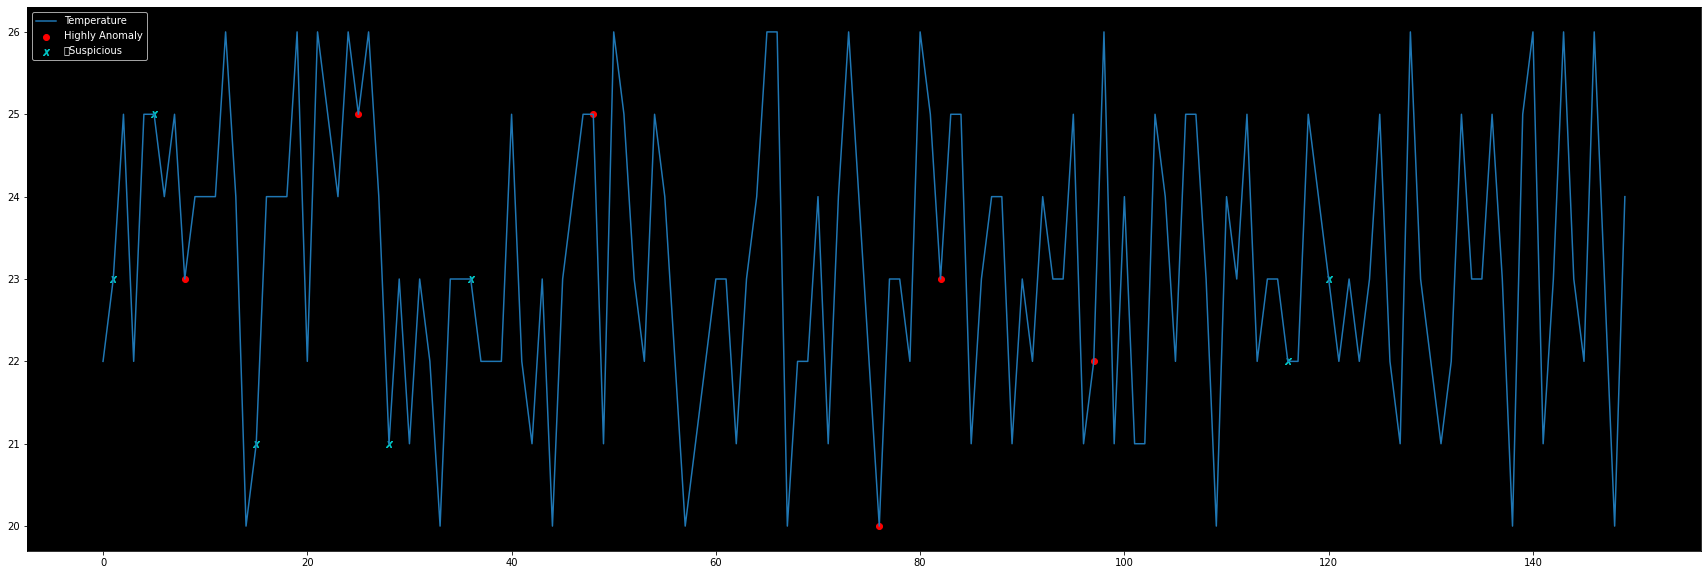

In [ ]:
threshold_1 = 0.97 # chosen one
threshold_2 = 0.94
AbnormalPos_high = (yvalpred["MayBeAnomaly"] > threshold_1)
AbnormalPos_low = ((yvalpred["MayBeAnomaly"] < threshold_1) & (yvalpred["MayBeAnomaly"] > threshold_2))
plt.figure(figsize=(30,10))
plt.rcParams['axes.facecolor'] = 'black'
plt.plot(yvalpred["temperature"], label = 'Temperature')
# plt.plot(yvalpred["temp_pred"], label = 'temp pred')
plt.scatter(yvalpred[AbnormalPos_high]["temperature"].index, yvalpred[AbnormalPos_high]["temperature"], marker='o', c='red', label = 'Highly Anomaly')
plt.scatter(yvalpred[AbnormalPos_low]["temperature"].index, yvalpred[AbnormalPos_low]["temperature"], marker='$X$', c='c', label = 'Suspicious')
leg = plt.legend(loc='upper left')
for text in leg.get_texts():
  text.set_color("white")
plt.savefig('great_visualize.jpg', format='jpg', dpi=213)
yvalpred.to_csv("great_data_for_demo.csv")

In [ ]:
tempList = []
for i in range(0,len(result)):
    if i in idxoutlier:
        tempList.append(1)
    else:
        tempList.append(0)
# tempList

In [ ]:
yvalpred['refine anomaly score'] = tempList

In [ ]:
anomaly_df = yvalpred.drop(columns=['MayBeAnomaly', 'temp_pred']).rename(columns = {'refine anomaly score':'is_anomaly'})
# anomaly_df.head(10)

In [ ]:
time_elapsed = datetime.datetime.now() - start_time
print('Time eslapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Time eslapsed (hh:mm:ss.ms) 0:01:53.081362


In [ ]:
## WANT TO UPDATE TO DB? UN-CMT
## I want to keep current data in the db as a good example!


# try:
#     # from cred import getPostgresCred
#     import psycopg2
#     host, database, user, password = getPostgresCred()
#     conn = psycopg2.connect(
#         host=host,
#         database=database,
#         user=user,
#         password=password,
#         port='5432')
#     print("okay 1 - connect");
#     cur = conn.cursor()
#     print("... Get the conn successfully!")
# except Exception as err:
#     print(f"You failed to connect posgres! {err}")

# query = '''create table if not exists datahub.isnomaly
# (date_time timestamp primary key not null,
# temperature float,
# is_anomaly int);'''

# cur.execute(query)

# update_table = '''insert into datahub.isnomaly
# (date_time, temperature, is_anomaly)
# values(%s, %s, %s)
# on conflict (date_time)
# do nothing;
# '''

# for i, row in anomaly_df.iterrows():
#     cur.execute(update_table, list(row))
#     conn.commit()


# conn.close()
